# Apple(AAPL)

In [34]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Download
stock = yf.download("AAPL", start="2018-01-01", end="2025-03-01")

stock.head()


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2018-01-02,40.479836,40.489237,39.774858,39.986353,102223600
2018-01-03,40.472786,41.017971,40.409341,40.543284,118071600
2018-01-04,40.660767,40.764164,40.437524,40.545619,89738400
2018-01-05,41.123711,41.210657,40.665476,40.757123,94640000
2018-01-08,40.970978,41.267067,40.872278,40.970978,82271200


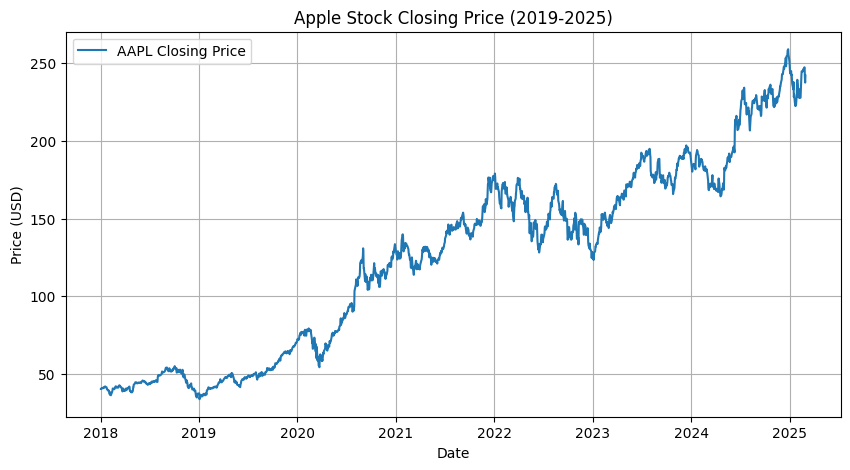

In [35]:
# Plot the closing price
plt.figure(figsize=(10,5))
plt.plot(stock['Close'], label='AAPL Closing Price')
plt.title('Apple Stock Closing Price (2018-2025)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()


In [36]:
from sklearn.preprocessing import MinMaxScaler

# Use only the 'Close' column for prediction
data = stock[['Close']]

# Normalize the data to a range between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Set the number of days to look back for prediction (e.g., 60 days)
time_steps = 60

# Prepare the data for LSTM (using past 60 days to predict the next day)
x_data = []
y_data = []

for i in range(time_steps, len(scaled_data)):
    x_data.append(scaled_data[i-time_steps:i, 0])
    y_data.append(scaled_data[i, 0])

# Convert lists to numpy arrays
import numpy as np
x_data, y_data = np.array(x_data), np.array(y_data)

# Reshape data to fit the model
x_data = np.reshape(x_data, (x_data.shape[0], x_data.shape[1], 1))

# Split into training and testing datasets (80% training, 20% testing)
train_size = int(len(x_data) * 0.8)
x_train, x_test = x_data[:train_size], x_data[train_size:]
y_train, y_test = y_data[:train_size], y_data[train_size:]


In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

# Create the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=1))  # Output for the predicted next day's price

# Compile and train the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, epochs=10, batch_size=32)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - loss: 0.0473
Epoch 2/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - loss: 8.7712e-04
Epoch 3/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 5.5238e-04
Epoch 4/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - loss: 4.9300e-04
Epoch 5/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 5.2532e-04
Epoch 6/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 5.3540e-04
Epoch 7/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 5.0447e-04
Epoch 8/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - loss: 4.7985e-04
Epoch 9/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - loss: 4.9043e-04
Epoch 10/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 4.5295e-04


In [38]:
def predict_future(model, data, time_steps, future_days):
    # Get the last `time_steps` days of data to start the prediction
    last_data = data[-time_steps:]

    # Initialize a list to hold the predicted values
    future_prices = []

    # Predict future stock prices day by day
    for _ in range(future_days):
        # Reshape the last data to be 3D as required by LSTM (1, time_steps, 1)
        last_data_reshaped = np.reshape(last_data, (1, time_steps, 1))

        # Predict the next price
        predicted_price = model.predict(last_data_reshaped)

        # Append the predicted price to the list
        future_prices.append(predicted_price[0][0])

        # Update the `last_data` by appending the new predicted value and removing the first element
        # Ensure the predicted value has the correct shape
        predicted_price_reshaped = np.reshape(predicted_price, (1, 1))  # Ensure the shape is (1, 1)
        last_data = np.append(last_data[1:], predicted_price_reshaped, axis=0)

    # Inverse transform the predictions to the original scale
    future_prices = scaler.inverse_transform(np.array(future_prices).reshape(-1, 1))

    return future_prices


# Predict stock prices for the next 30 days (or however many you need)
future_prices = predict_future(model, scaled_data, time_steps, 30)

# Print future stock prices (e.g., for April 2025)
future_dates = pd.date_range(stock.index[-1], periods=31, freq='D')[1:]  # Skip the first date (already present in the data)

# Create a DataFrame with the predictions
future_df = pd.DataFrame(data=future_prices, index=future_dates, columns=["Predicted Price"])

# Display the predicted future stock prices for the next 30 days
print(future_df)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━

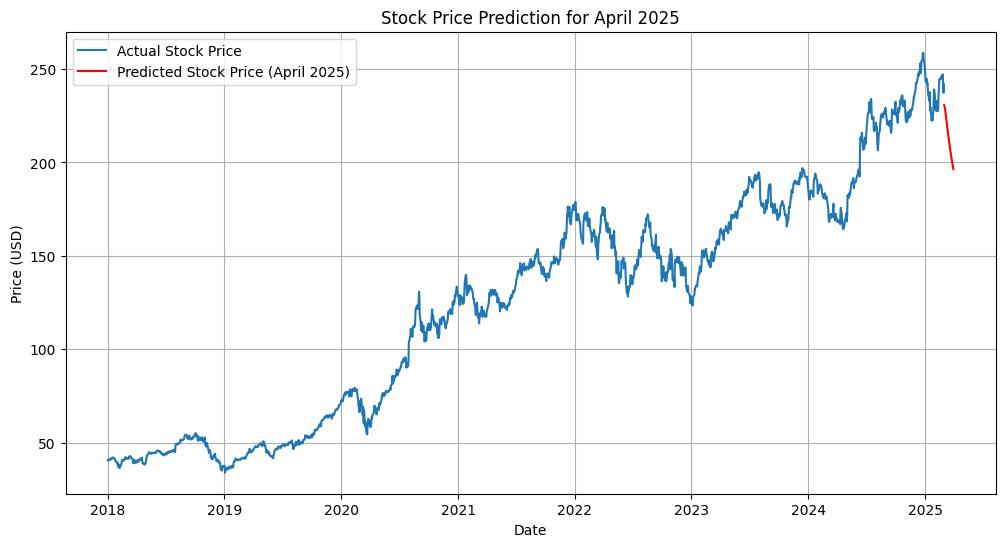

In [39]:
# Plot the actual and predicted stock prices
plt.figure(figsize=(12,6))
plt.plot(stock['Close'], label='Actual Stock Price')
plt.plot(future_df.index, future_df['Predicted Price'], label='Predicted Stock Price (April 2025)', color='red')
plt.title('Stock Price Prediction for April 2025')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()


## Deep Learning Comparsion

In [40]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam

# Create a function to build the LSTM model
def build_lstm_model(time_steps, features=1):
    model = Sequential()

    # First LSTM Layer with Dropout to prevent overfitting
    model.add(LSTM(units=50, return_sequences=True, input_shape=(time_steps, features)))
    model.add(Dropout(0.2))  # Dropout layer to regularize

    # Second LSTM Layer
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))

    # Fully connected layer to output the prediction
    model.add(Dense(units=1))

    # Compile the model with the Adam optimizer and MSE loss function
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

    return model


In [41]:
# Split data into training and testing sets
train_size = int(len(scaled_data) * 0.8)  # Use 80% of the data for training
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Prepare X_train and y_train
X_train, y_train = [], []
for i in range(time_steps, len(train_data)):
    X_train.append(train_data[i-time_steps:i, 0])
    y_train.append(train_data[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape X_train to 3D array for LSTM (samples, time_steps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Build and train the model
model = build_lstm_model(time_steps)
model.fit(X_train, y_train, epochs=20, batch_size=32)


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - loss: 0.0555
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 0.0025
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 0.0017
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.0019
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.0015
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 0.0017
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - loss: 0.0016
Epoch 8/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.0016
Epoch 9/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.0014
Epoch 10/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0015
Epoch 11/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - loss: 0.0016
Epoch 12/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - loss: 0.0014
Epoch 13/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.0014
Epoch 14/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0014
Epoch 15/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - loss: 0.0014
Epoch 16/20
44/

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step


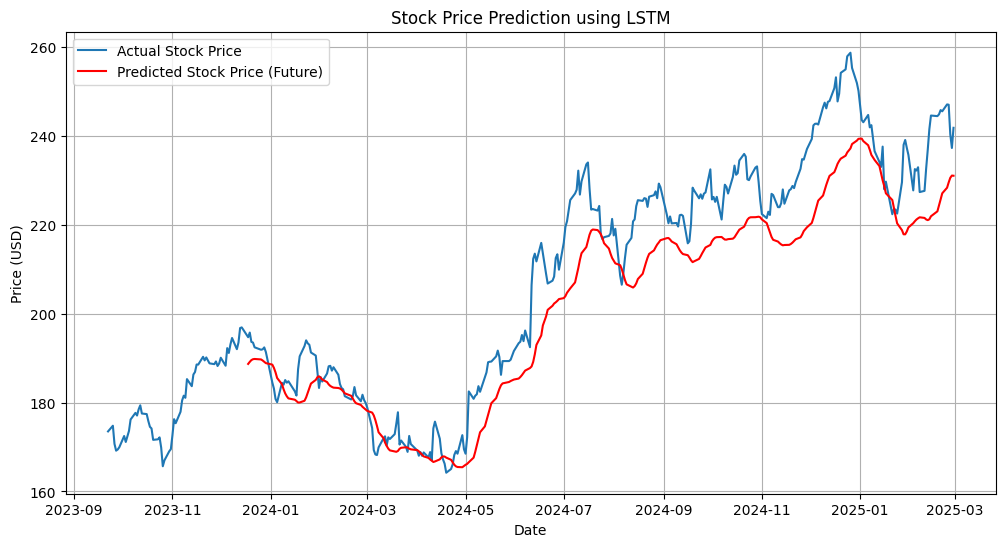

In [42]:
# Prepare the test data in the same way
X_test, y_test = [], []
for i in range(time_steps, len(test_data)):
    X_test.append(test_data[i-time_steps:i, 0])
    y_test.append(test_data[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test)

# Reshape X_test for LSTM
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Make predictions
predictions = model.predict(X_test)

# Inverse the scaling transformation
predictions = scaler.inverse_transform(predictions)

# Visualize the predictions
plt.figure(figsize=(12,6))
plt.plot(stock.index[train_size:], stock['Close'][train_size:], label='Actual Stock Price')
plt.plot(stock.index[train_size+time_steps:], predictions, label='Predicted Stock Price (Future)', color='red')
plt.title('Stock Price Prediction using LSTM')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()


In [43]:
from sklearn.metrics import mean_squared_error
import math

# Calculate RMSE
rmse = math.sqrt(mean_squared_error(y_test, predictions))
print(f'Root Mean Squared Error (RMSE): {rmse}')


Root Mean Squared Error (RMSE): 202.17893187287348
